## Stock Performance Tracker


## Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils, read_utils, draw_utils, process_utils, const

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")


## Read data


### Log table


In [3]:
log_df = read_utils.read_log()
# log_df.tail()


### Cashflow


In [4]:
cf_df = read_utils.read_cashflow(const.ACC_USER_DICT, const.ACC_COMBINED_NAME)
# # Drop specific users' columns
# cf_df = cf_df[const.ALL_ACC_NAME_L]
# cf_df.tail()


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


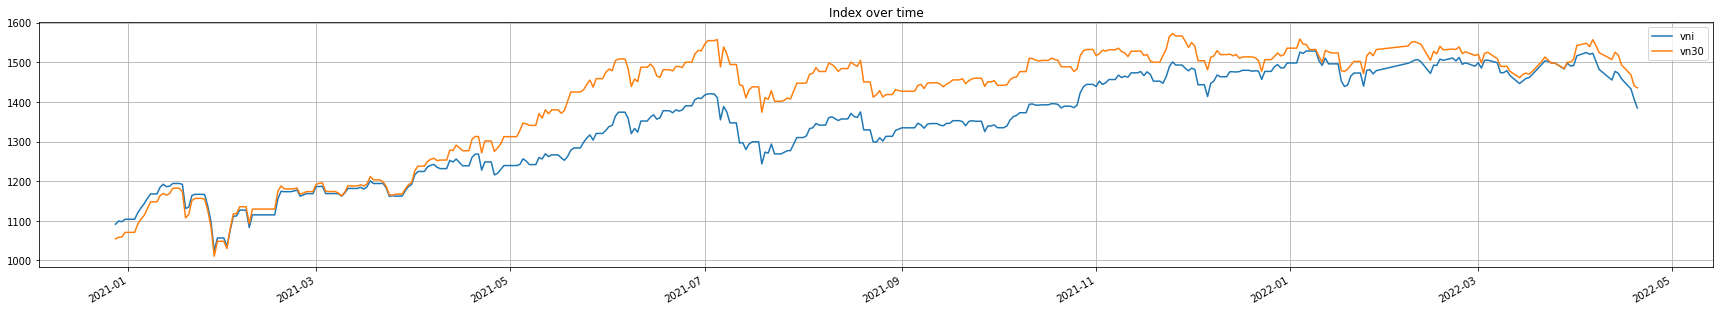

In [5]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in const.INDEX_NAME_L
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


## [Process] Processing


### Adding diff columns


In [6]:
log_df = process_utils.add_diff_column(log_df)
# log_df.tail()


### Remove unchanged dates from `log_df`


In [7]:
log_df = process_utils.remove_unchanged_rows(log_df)
# log_df.tail()

### Compensating diff with cashflow


In [8]:
log_df = process_utils.compensate_diff_with_cashflow(df=log_df, cashflow_df=cf_df, acc_name_l=const.ACC_NAME_L)
# log_df.tail()

### Adding Combined columns


In [9]:
# Add acc combined cols
log_df = process_utils.add_acc_combined_cols(
    log_df,
    acc_combined_name=const.ACC_COMBINED_NAME,
    acc_name_l=const.ACC_NAME_L,
)
# Add index combined cols
log_df = process_utils.add_index_combined_cols(
    log_df,
    index_combined_name=const.INDEX_COMBINED_NAME,
    index_name_l=const.INDEX_NAME_L,
)
# log_df.tail()


### Calculating diff percent & aux diff percent


In [10]:
log_df = process_utils.add_diff_percent(log_df, const.ALL_ACC_NAME_L, const.ALL_INDEX_NAME_L)
# log_df.tail()

## [Chart] NAV stack

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_38313/1150905032.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks() / 1_000_000))


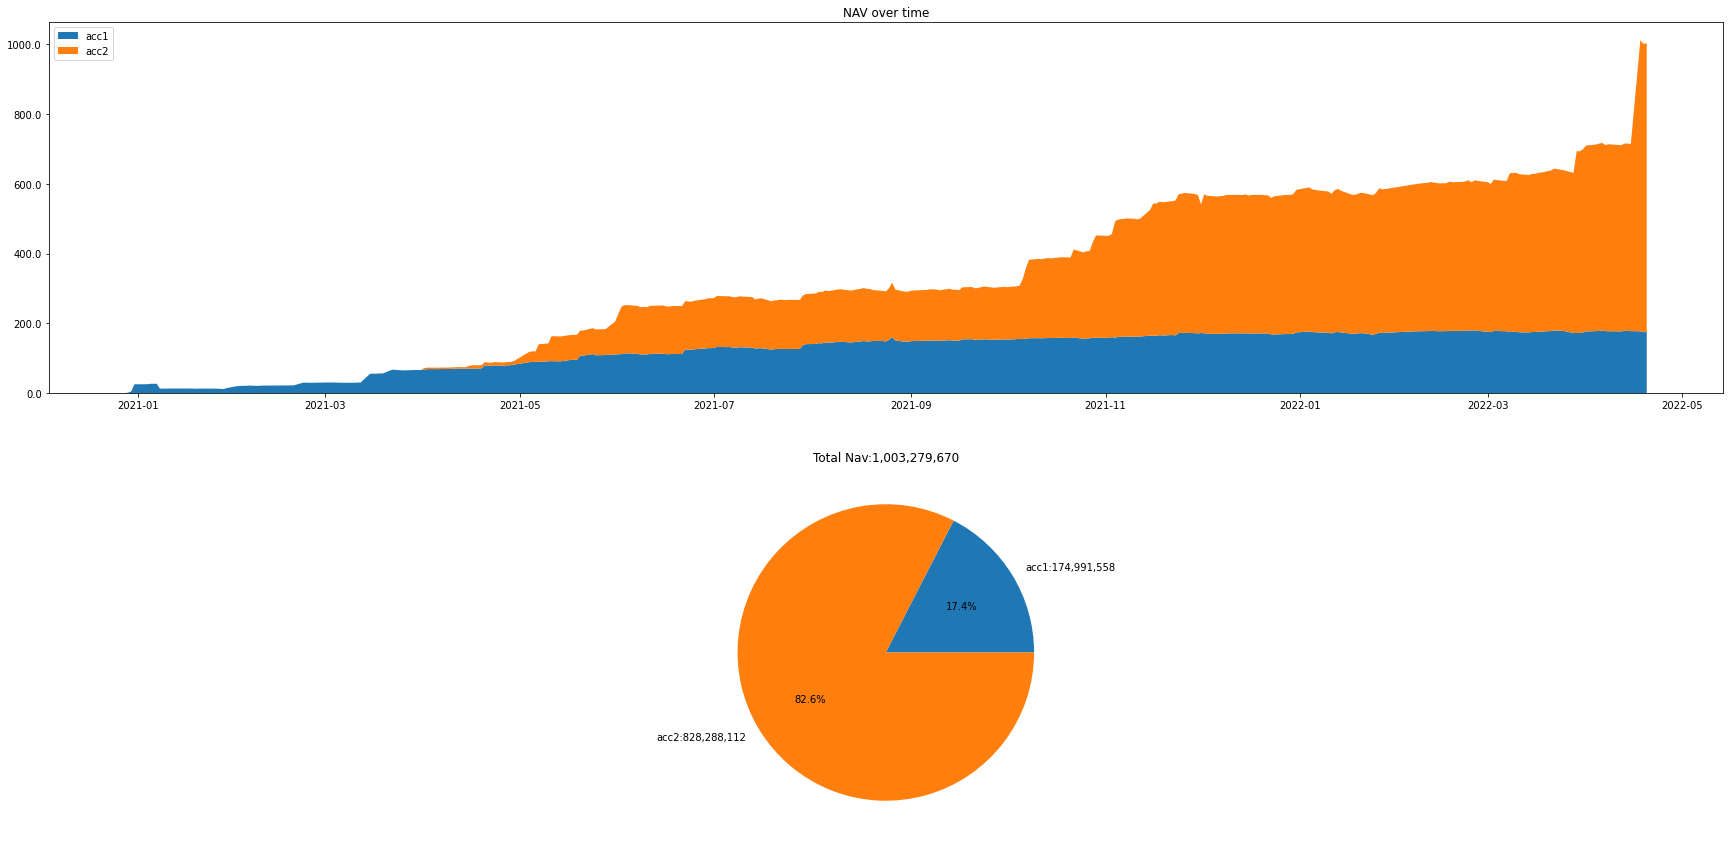

In [15]:
fig, (ax1, ax2) = plt.subplots(figsize=(30, 15), nrows=2)  # type: ignore

# Pie chart
nav_l = [log_df[acc_name].iloc[-1] for acc_name in const.ACC_NAME_L]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(const.ACC_NAME_L, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")

plt.show()


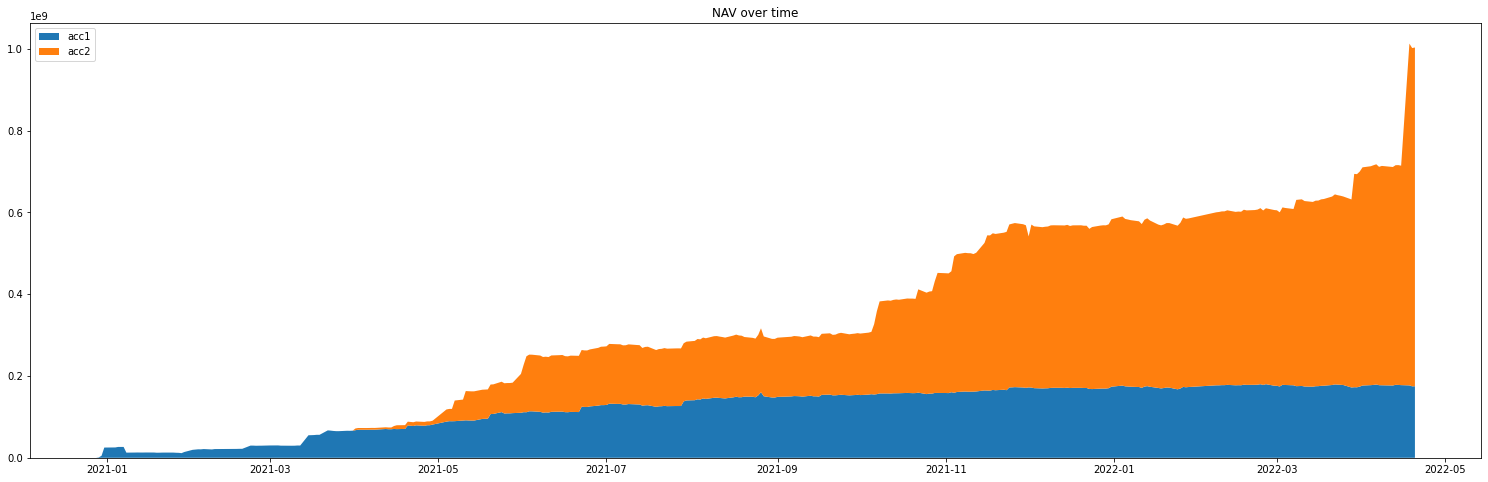

In [16]:
y_list = [log_df[acc_name] for acc_name in const.ACC_NAME_L]

draw_utils.plot_nav_stackplot(
    x=log_df.index,  # type: ignore
    y=y_list,
    labels=const.ACC_NAME_L,
)


## [Chart] NAV pie

## [Chart] Profit

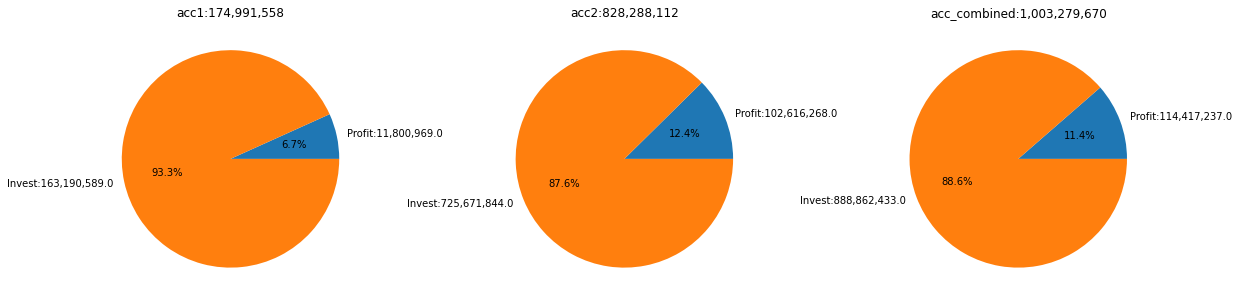

In [13]:
fig, ax_l = plt.subplots(figsize=(20, 5), ncols=3, facecolor="white")  # type: ignore

for name, ax in zip(const.ALL_ACC_NAME_L, ax_l):  # type: ignore
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest

    profit_label = f"Profit:{profit:,}"
    invest_label = f"Invest:{invest:,}"

    ax.pie([profit, invest], labels=[profit_label, invest_label], autopct="%1.1f%%")
    ax.set_title(f"{name}:{nav:,}")

plt.show()


## [Chart] Diff percent


### Histogram

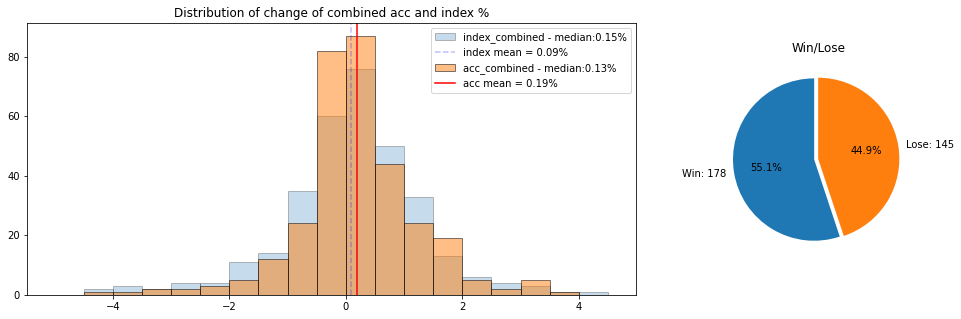

In [14]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{const.INDEX_COMBINED_NAME}_diff_p"] * 100
acc_diff_p_l = log_df[f"{const.ACC_COMBINED_NAME}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
index_combined_median = index_diff_p_l.median()
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=f"{const.INDEX_COMBINED_NAME} - median:{index_combined_median:.2f}%",
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# acc histogram
acc_combined_median = acc_diff_p_l.median()
ax1.hist(
    acc_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=f"{const.ACC_COMBINED_NAME} - median:{acc_combined_median:.2f}%",
)
acc_diff_p_mean = acc_diff_p_l.mean()  # type: ignore
ax1.axvline(
    acc_diff_p_mean,
    color="red",
    label="acc mean = %.2f%%" % acc_diff_p_mean,
)


ax1.set_title("Distribution of change of combined acc and index %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (acc_diff_p_l > index_diff_p_l).sum()
lose_num = (acc_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


## [Chart] Daily


In [15]:
# Filter 10 latest days
recent_daily_df = process_utils.filter_latest_x_rows(log_df, row_num= 10)


### Latest growth

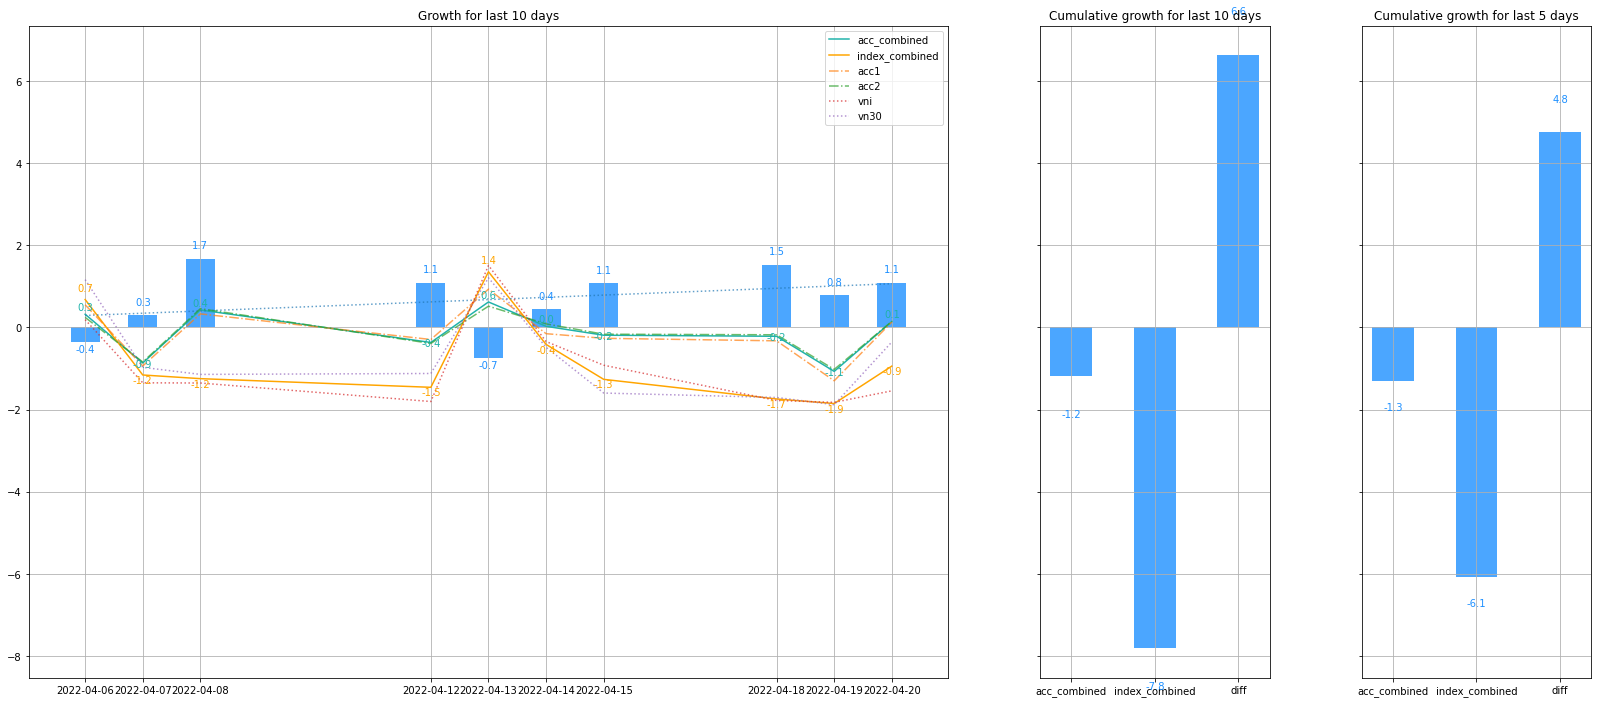

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(28, 12),
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [4, 1, 1]},
)  # type: ignore

# * Last x days line plot

for combined_name, color in zip(
    [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME], ["lightseagreen", "orange"]
):
    x = recent_daily_df.index
    y = recent_daily_df[f"{combined_name}_diff_p"] * 100
    ax1.plot_date(
        x,
        y,
        fmt="-",
        label=combined_name,
        color=color,
    )
    utils.add_labels(ax1, x, y, color=color)

recent_diff_df = (
    recent_daily_df[f"{const.ACC_COMBINED_NAME}_diff_p"]
    - recent_daily_df[f"{const.INDEX_COMBINED_NAME}_diff_p"]
) * 100

ax1.bar(
    recent_daily_df.index,
    recent_diff_df,
    width=0.5,
    alpha=0.8,
    color="dodgerblue",
)
utils.add_labels(ax1, recent_daily_df.index, recent_diff_df, color="dodgerblue")

# Trendline
first_date = recent_daily_df.index[0]
x = [(date - first_date).days for date in recent_daily_df.index]
utils.add_trend_line(ax1, ticks=recent_daily_df.index, x=x, y=recent_diff_df)


for single_name in const.ACC_NAME_L:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        fmt="-.",
        alpha=0.7,
        label=single_name,
    )

for single_name in const.INDEX_NAME_L:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        fmt=":",
        alpha=0.7,
        label=single_name,
    )


ax1.set_title("Growth for last 10 days")
ax1.set_xticks(ticks=recent_daily_df.index)
ax1.legend()
ax1.grid(True)


# * Cumulative growth bar plot
def _plot_cum_growth(df: pd.DataFrame, ax: plt.Axes, day_num: int) -> None:
    cum_acc_growth = (df[f"{const.ACC_COMBINED_NAME}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_index_growth = (df[f"{const.INDEX_COMBINED_NAME}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_diff_growth = cum_acc_growth - cum_index_growth
    x = [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME, "diff"]
    y = [cum_acc_growth, cum_index_growth, cum_diff_growth]
    ax.bar(
        x,
        y,
        width=0.5,
        alpha=0.8,
        color="dodgerblue",
    )
    ax.set_title(f"Cumulative growth for last {day_num} days")
    ax.grid(True)
    utils.add_labels(ax, x, y,color="dodgerblue")


_plot_cum_growth(recent_daily_df, ax2, 10)
# _plot_cum_growth(recent_daily_df.iloc[-5:], ax3, 5)
_plot_cum_growth(process_utils.filter_latest_x_rows(recent_daily_df, row_num= 5), ax3, 5)

plt.show()


In [17]:
# recent_daily_df  # type: ignore


### XIRR

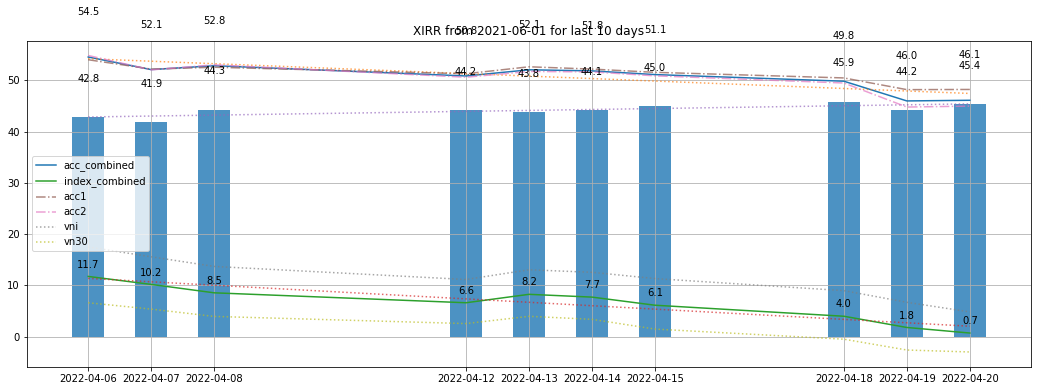

In [18]:
anchor_date = "2021-06-01"

xirr_data = {name: [] for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L}
for idx in recent_daily_df.index:
    for name in const.ALL_ACC_NAME_L:
        xirr_data[name].append(
            utils.calc_cashflow_xirr(
                cashflow_df=cf_df,
                log_df=log_df,
                anchor_date=anchor_date,
                date_idx=idx,
                col_name=name,
                user_name_combined_l=const.ALL_ACC_NAME_L,
            )
        )
    for idx_name in const.ALL_INDEX_NAME_L:
        xirr_data[idx_name].append(
            utils.calc_index_xirr(log_df, anchor_date, idx, idx_name)
        )
xirr_df = pd.DataFrame(xirr_data, index=recent_daily_df.index)


fig, ax1 = plt.subplots(figsize=(18, 6))  # type: ignore

# * Last x days line plot

for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[combined_name] * 100,  # type: ignore
        fmt="-",
        label=combined_name,
    )
    utils.add_labels(ax1, xirr_df.index, xirr_df[combined_name] * 100)  # type: ignore

    # Trendline
    first_date = xirr_df.index[0]
    x = [(date - first_date).days for date in xirr_df.index]
    utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=xirr_df[combined_name] * 100)  # type: ignore

recent_diff = (xirr_df[const.ACC_COMBINED_NAME] - xirr_df[const.INDEX_COMBINED_NAME]) * 100  # type: ignore

ax1.bar(
    xirr_df.index,
    recent_diff,
    width=0.5,
    alpha=0.8,
)
utils.add_labels(ax1, xirr_df.index, recent_diff)  # type: ignore

# Trendline
first_date = xirr_df.index[0]
x = [(date - first_date).days for date in xirr_df.index]
utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=recent_diff)  # type: ignore


for single_name in const.ACC_NAME_L:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        fmt="-.",
        alpha=0.7,
        label=single_name,
    )

for single_name in const.INDEX_NAME_L:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        fmt=":",
        alpha=0.7,
        label=single_name,
    )


ax1.set_title(f"XIRR from {anchor_date} for last 10 days")
ax1.set_xticks(ticks=xirr_df.index)
ax1.legend(loc="center left")
ax1.grid(True)

plt.show()


In [19]:
# xirr_df  # type: ignore


### Income

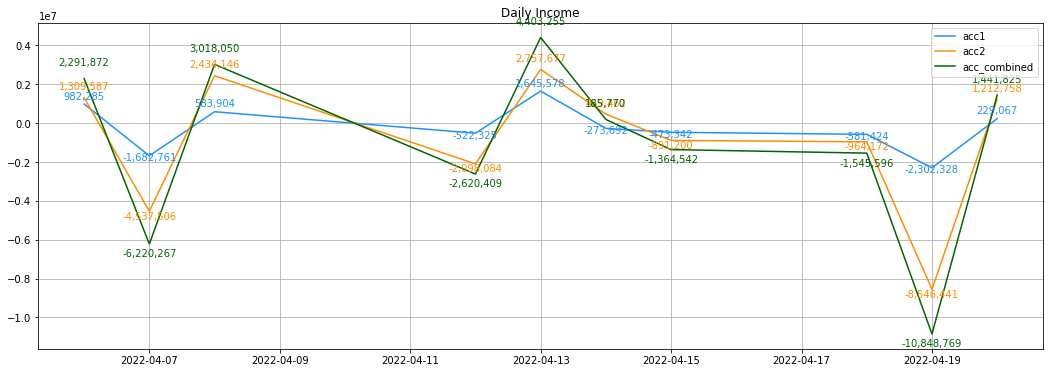

In [20]:
fig, ax = plt.subplots(figsize=(18, 6))  # type: ignore

for name, color in zip(const.ALL_ACC_NAME_L, ["dodgerblue", "darkorange", "darkgreen"]):
    income_l = recent_daily_df[f"{name}_diff"]
    ax.plot_date(
        recent_daily_df.index,
        income_l,  # type: ignore
        fmt="-",
        label=name,
        color=color,
    )

    label_l = [f"{income:,.0f}" for income in income_l]
    utils.add_labels(ax, recent_daily_df.index, income_l,label_l=label_l, color=color)  # type: ignore

ax.set_title("Daily Income")
ax.grid(True)
ax.legend()

plt.show()


In [21]:
# recent_daily_df  # type: ignore


### Growth time series


In [22]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df:pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in const.ALL_ACC_NAME_L + const.ALL_INDEX_NAME_L:
        # calculate growth using cumulative product since anchor date
        
        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)
        
    for name in const.ALL_ACC_NAME_L:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date,
                date_idx,
                name,
                const.ALL_ACC_NAME_L,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
        
    for name in const.ALL_INDEX_NAME_L:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_index_xirr(
                log_df,
                anchor_date,
                date_idx,
                name,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
    
    return df


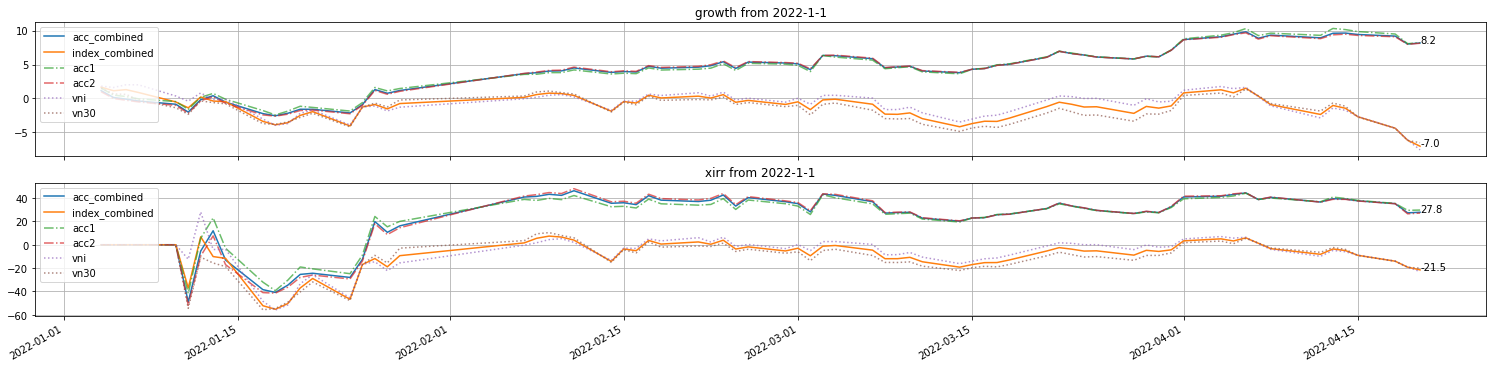

In [23]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2022-1-1"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, growth_xirr_df: pd.DataFrame, type: str):
    # Normalize growth from 0
    if type == "growth":
        growth_xirr_df = growth_xirr_df.applymap(lambda e: e - 100)

    for combined_name in [const.ACC_COMBINED_NAME, const.INDEX_COMBINED_NAME]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            fmt="-",
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in const.ACC_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt="-.",
            alpha=0.7,
            label=single_name,
        )

    for single_name in const.INDEX_NAME_L:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            fmt=":",
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()


_plot_overall_growth_xirr(ax1, growth_xirr_df, "growth")
_plot_overall_growth_xirr(ax2, growth_xirr_df, "xirr")

plt.show()


In [24]:
# growth_xirr_df  # type: ignore


## [Process] Add period info


In [25]:
log_df = process_utils.add_period_cols(log_df)
# log_df.tail()


## [Chart] Weekly

In [26]:
weekly_df = process_utils.get_period_df(
    period_symbol="W",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Not enough space to plot every week
weekly_df = process_utils.filter_latest_x_rows(df=weekly_df, row_num=20)  # type: ignore


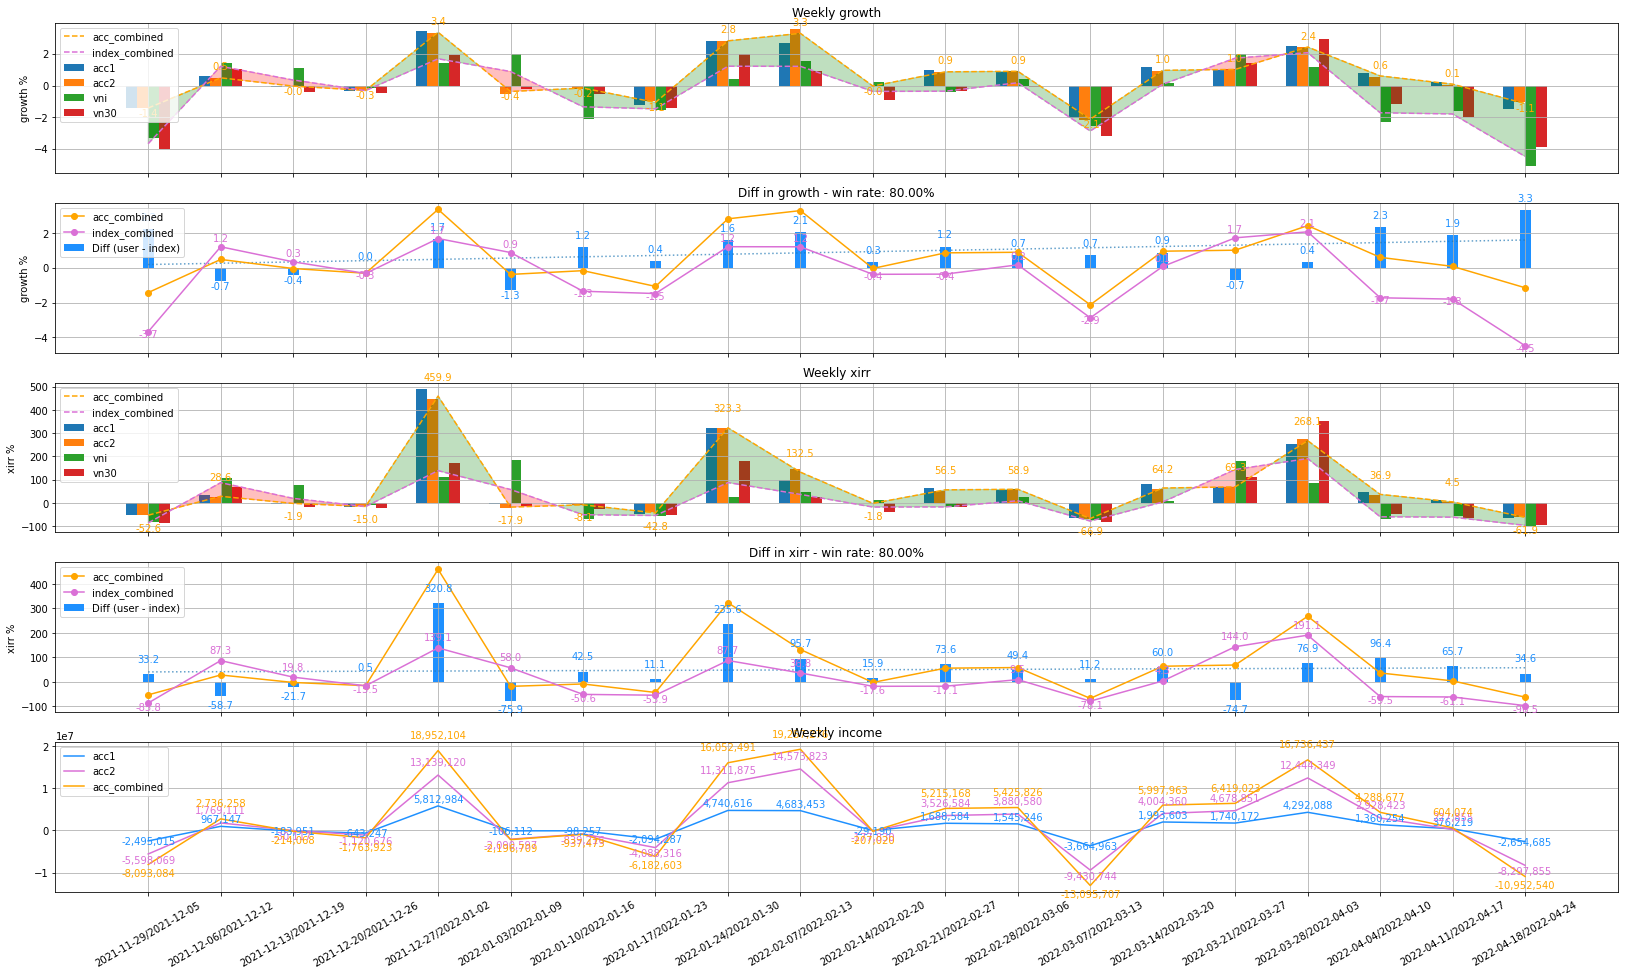

In [27]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=weekly_df,
    period_name="Weekly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [28]:
# weekly_df.tail()

## [Chart] Monthly


In [29]:
monthly_df = process_utils.get_period_df(
    period_symbol="M",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)

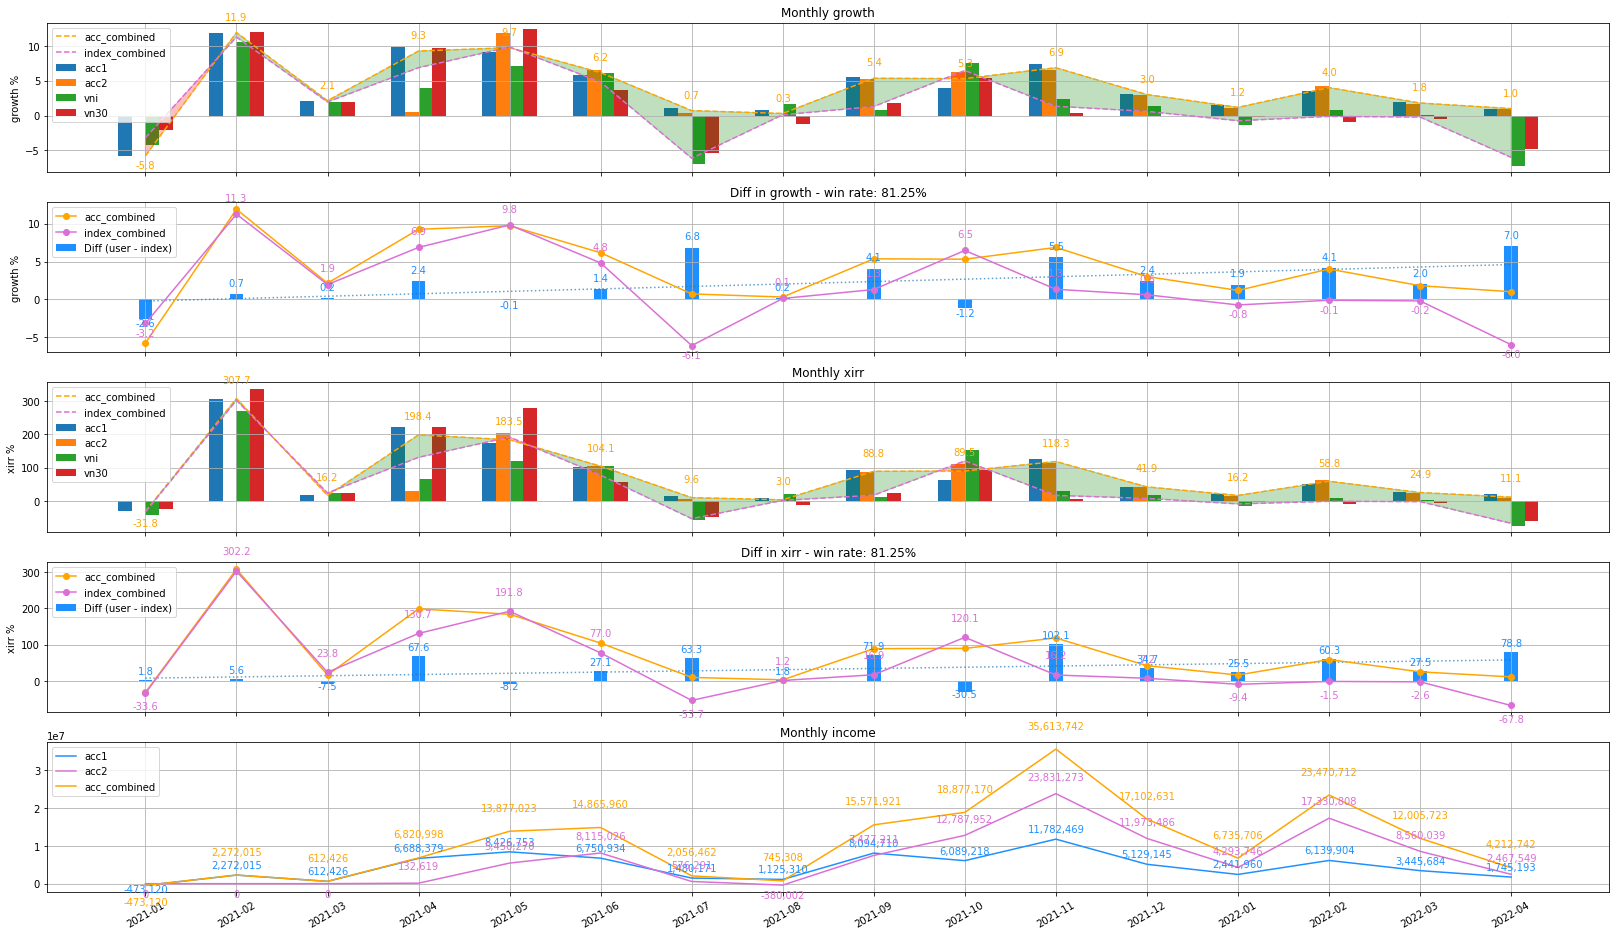

In [30]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=monthly_df,
    period_name="Monthly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [31]:
# monthly_df # type: ignore

## Quaterly


In [32]:
quaterly_df = process_utils.get_period_df(
    period_symbol="Q",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020Q4
quaterly_df.drop(["2020Q4"], inplace=True)

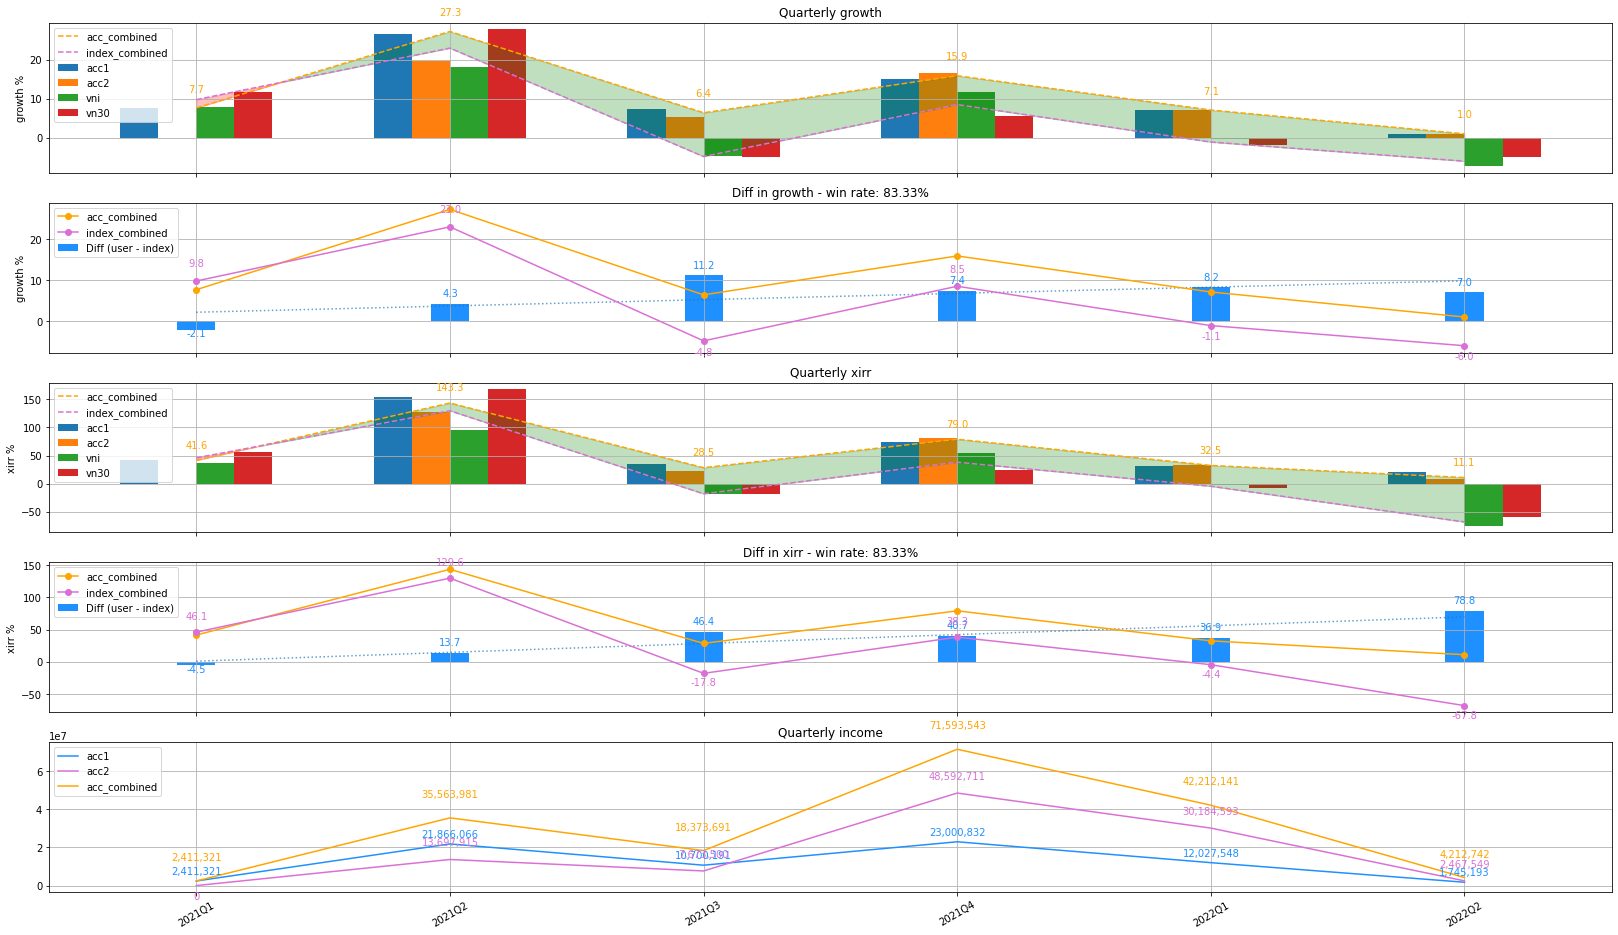

In [33]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=quaterly_df,
    period_name="Quarterly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)


In [34]:
# quaterly_df  # type: ignore


## Yearly

In [35]:
yearly_df = process_utils.get_period_df(
    period_symbol="Y",
    df=log_df,
    cashflow_df=cf_df,
    all_acc_name_l=const.ALL_ACC_NAME_L,
    index_name_combined_l=const.ALL_INDEX_NAME_L,
)
# Insufficient data for 2020
yearly_df.drop(["2020"], inplace=True)

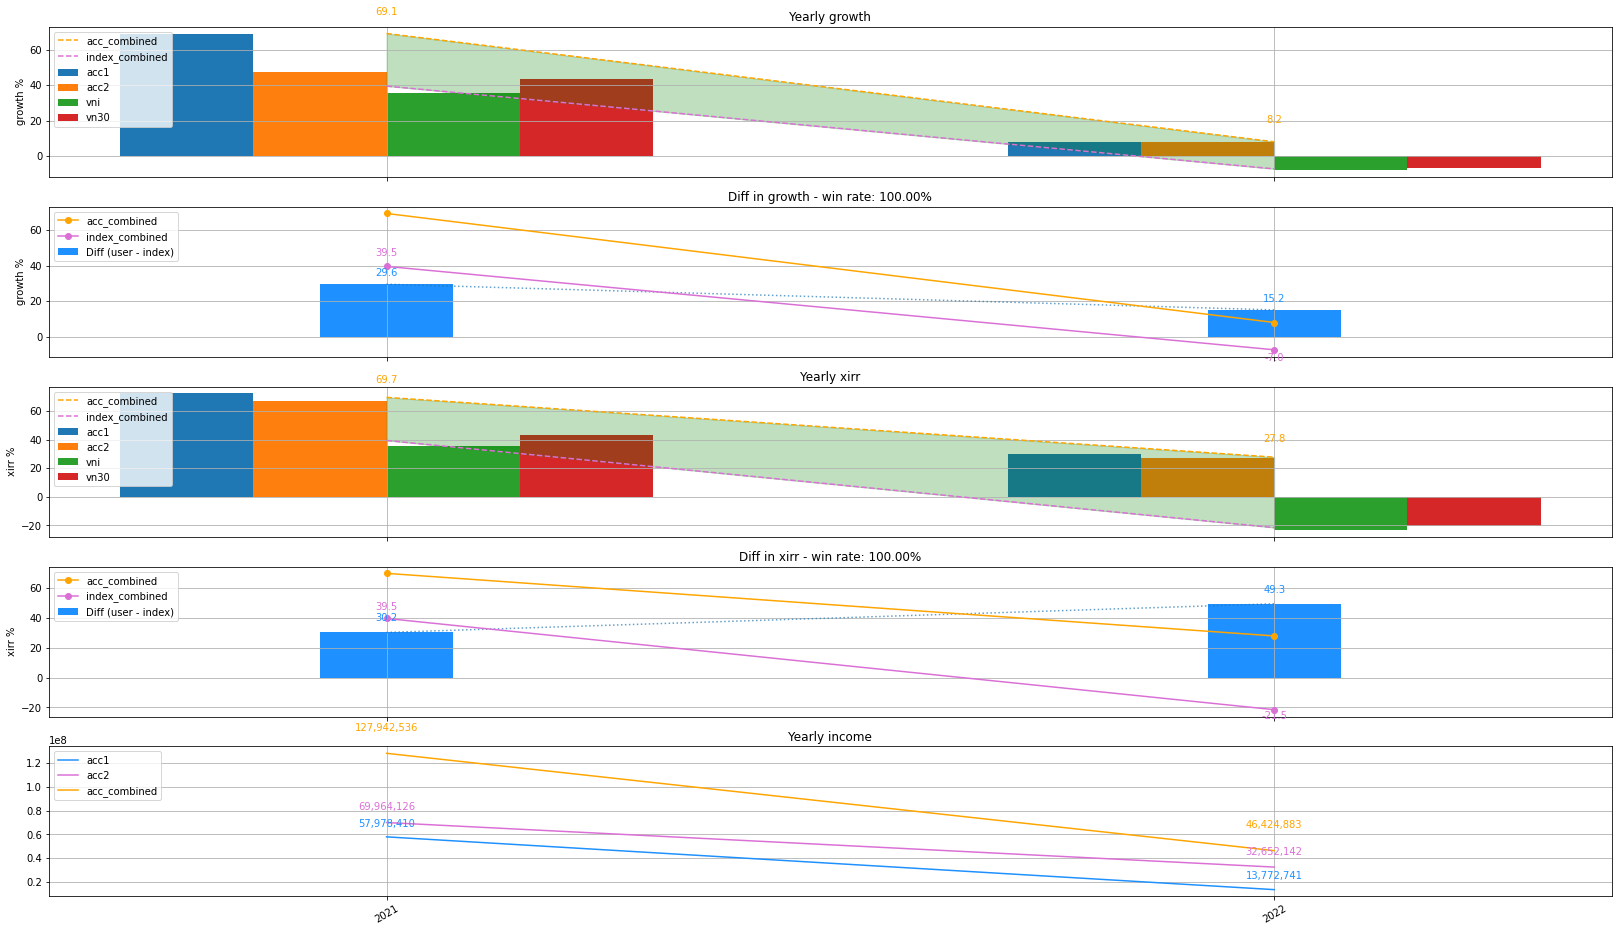

In [36]:
draw_utils.plot_period_growth_xirr(
    growth_xirr_df=yearly_df,
    period_name="Yearly",
    acc_name_l=const.ACC_NAME_L,
    index_name_l=const.INDEX_NAME_L,
    acc_combined_name=const.ACC_COMBINED_NAME,
    index_combined_name=const.INDEX_COMBINED_NAME,
    all_acc_name_l=const.ALL_ACC_NAME_L,
)

In [37]:
# yearly_df # noqa

## User Analysis

In [38]:
acc_name = 'acc2'
user_name_l = const.ACC_USER_DICT[acc_name]

In [39]:
# Get data from log_df
acc_df = log_df[[acc_name, f"{acc_name}_diff"]]

# Get data from cashflow dataframe
acc_cf_df = cf_df[user_name_l]
acc_cf_df[f"{acc_name}_cf"] = acc_cf_df.sum(axis=1)
acc_cf_df = acc_cf_df.rename(
    columns={user_name: f"{user_name}_cf" for user_name in user_name_l}
)

user_df = pd.concat([acc_df, acc_cf_df], axis=1)
user_df.fillna(0, inplace=True)

user_df["day_start_nav"] = user_df[acc_name] - user_df[f"{acc_name}_diff"]

# Delete rows with day_start_nav == 0 (the first row in this case)
user_df = user_df[user_df["day_start_nav"] != 0]

# Calculating share of each user
yesterday_user_nav_dict = {user_name: 0.0 for user_name in user_name_l}
for date in user_df.index:
    day_start_nav: float = user_df.loc[date, "day_start_nav"]  # type:ignore

    for user_name in user_name_l:
        # Get day start nav using yesterday nav and today cashflow
        user_day_start_nav: float = (
            # Investment is saved as negative number in cashflow
            yesterday_user_nav_dict[user_name]
            - user_df.loc[date, f"{user_name}_cf"]  # type:ignore
        )

        user_df.loc[date, f"{user_name}_day_start_nav"] = user_day_start_nav

        user_share = user_day_start_nav / day_start_nav
        user_df.loc[date, f"{user_name}_share"] = user_share

        user_diff: float = (
            user_df.loc[date, f"{acc_name}_diff"] * user_share  # type:ignore
        )
        user_df.loc[date, f"{user_name}_diff"] = user_diff

        user_day_end_nav = user_day_start_nav + user_diff
        user_df.loc[date, f"{user_name}"] = user_day_end_nav
        yesterday_user_nav_dict[user_name] = user_day_end_nav

user_df.tail(10)


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_3515/3492504508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_cf_df[f"{acc_name}_cf"] = acc_cf_df.sum(axis=1)


,acc2,acc2_diff,tl_cf,la_cf,acc2_cf,day_start_nav,tl_day_start_nav,tl_share,tl_diff,tl,la_day_start_nav,la_share,la_diff,la
date,,,,,,,,,,,,,,
2022-04-06,538461472.0,1309587.0,0.0,0.0,0.0,537151885.0,5.371519e+08,1.0000,1.309587e+06,5.384615e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-07,533923966.0,-4537506.0,0.0,0.0,0.0,538461472.0,5.384615e+08,1.0000,-4.537506e+06,5.339240e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-08,536358112.0,2434146.0,0.0,0.0,0.0,533923966.0,5.339240e+08,1.0000,2.434146e+06,5.363581e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-12,534260028.0,-2098084.0,0.0,0.0,0.0,536358112.0,5.363581e+08,1.0000,-2.098084e+06,5.342600e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-13,537017705.0,2757677.0,0.0,0.0,0.0,534260028.0,5.342600e+08,1.0000,2.757677e+06,5.370177e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-14,537477167.0,459462.0,0.0,0.0,0.0,537017705.0,5.370177e+08,1.0000,4.594620e+05,5.374772e+08,0.000000e+00,0.0000,0.000000e+00,0.000000e+00
2022-04-15,536585967.0,-891200.0,0.0,0.0,0.0,537477167.0,5.374772e+08,1.0000,-8.912000e+05,5.365860e+08,0.000000e+00,0.0000,-0.000000e+00,0.000000e+00
2022-04-18,835621795.0,-964172.0,0.0,-300000000.0,-300000000.0,836585967.0,5.365860e+08,0.6414,-6.184196e+05,5.359675e+08,3.000000e+08,0.3586,-3.457524e+05,2.996542e+08
2022-04-19,827075354.0,-8546441.0,0.0,0.0,0.0,835621795.0,5.359675e+08,0.6414,-5.481684e+06,5.304859e+08,2.996542e+08,0.3586,-3.064757e+06,2.965895e+08


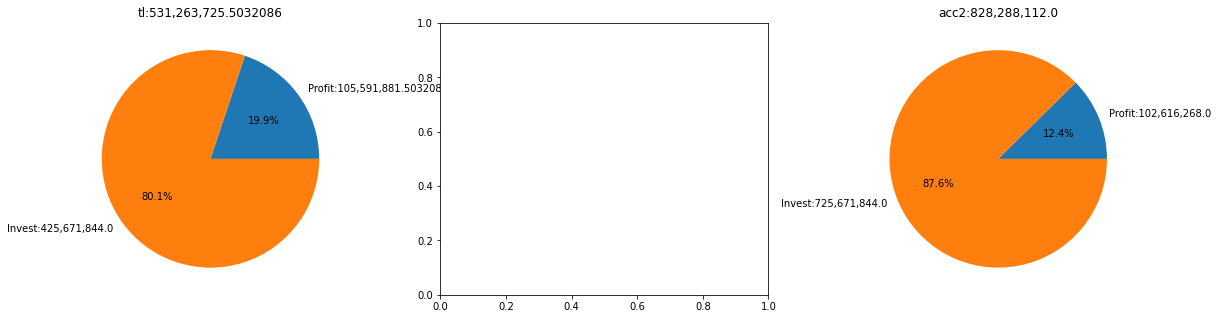

In [40]:
pie_num = len(user_name_l) + 1
fig, ax_l = plt.subplots(figsize=(20, 5), ncols=pie_num, facecolor="white")  # type: ignore

for name, ax in zip(const.ACC_USER_DICT[acc_name] + [acc_name], ax_l):  # type: ignore
    nav = user_df[name].iloc[-1]
    invest = -user_df[f"{name}_cf"].sum()
    if nav < invest:
        continue
    profit = nav - invest

    profit_label = f"Profit:{profit:,}"
    invest_label = f"Invest:{invest:,}"

    ax.pie([profit, invest], labels=[profit_label, invest_label], autopct="%1.1f%%")
    ax.set_title(f"{name}:{nav:,}")

plt.show()